## Digit Recognizer Using Convolutional Neural Networks With Keras

Convolutional Neural Network(CNN) is a class of deep neural networks. This techniques most commonly applied to analyzing visual imagery. This models used for Image Classification, Segmentation, Object Detection and many other image processing tasks. 
In this kernel, I will be covering a few famous CNN architectures. We are using keras library for the modeling.
Few of the models covering this kernel,

1. VGG Net (Visual Geometry Group)
1. ResNet
1. Dense Net
1. Inception Net
1. Xception Net

We will start with MNIST data, Digit Recognizer problem.
https://www.kaggle.com/c/digit-recognizer/overview

In [7]:
##Load Data
import numpy as np
import pandas as pd

input_train = pd.read_csv("../input/digit-recognizer/train.csv")
input_test = pd.read_csv("../input/digit-recognizer/test.csv")
print("Train data Shape : "+str(input_train.shape))
print("Test data Shape : "+str(input_test.shape))
#Check any missing data
print("Any missing data : "+str(np.any(input_train.isnull().sum())))
input_train.head(2)

Train data Shape : (42000, 785)
Test data Shape : (28000, 784)
Any missing data : False


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
##Prepare
Y_train = input_train["label"]
X_train = input_train.drop(labels = ["label"],axis = 1) 
# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
X_train = X_train.values.reshape(-1,28,28,1)
print("Features Shape : "+str(X_train.shape))
print("Labels Shape : "+str(Y_train.shape))
input_train.groupby("label",axis=0).size()

del input_train # free some space

Features Shape : (42000, 28, 28, 1)
Labels Shape : (42000,)


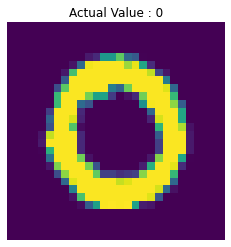

In [9]:
#View Sample
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(X_train[1][:,:,0])
plt.title("Actual Value : "+str(Y_train.iloc[1]))
plt.axis('off')
plt.show()

In [10]:
#Normalize
X_train = X_train / 255
X_train  = X_train.round()
input_test = input_test / 255
input_test  = input_test.round()

### One hot encoding on labels
We can observe that labels are in the range of 0-9, but for clasification we will convert that into onehot encoding. Refer : https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/

In [11]:
# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
Y_train = to_categorical(Y_train, num_classes = 10)

### Cross Validation
We need to split our data set for validation. Read more about it : https://towardsdatascience.com/why-and-how-to-cross-validate-a-model-d6424b45261f


In [12]:
from sklearn.model_selection import train_test_split
random_seed = 2
# Split the train and the validation set for the fitting
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=random_seed)

## Data Augmentation
<span>**Why** :  to create more images for training data set.<span>
    
<span>**How** : By modifing existing images. <span>

https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/

In [13]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

### Deep Netural Network Modeling

In [14]:
###Loading libraries
from keras.models import Sequential, Model
from keras.layers import Input,concatenate,DepthwiseConv2D,Activation, Dense, Dropout, Flatten, Conv2D, MaxPool2D, MaxPooling2D, BatchNormalization
from keras.optimizers import RMSprop, SGD
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint

We are planning to train our model iteratively. So, We need to save the best model and also if we find out accuracy is going to outof control we are reducing our lerning rate.
I'm using keras callbacks for that.

In [15]:
def evaluate_model(model,X_train,Y_train,X_val,Y_val,saveModelName,epochs,batch_size):
    filepath=saveModelName+".hdf5"
    best_accuracy_model = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
    learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.00001)
    history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction,best_accuracy_model]) 
    model.load_weights(filepath)
    return model,history

In [16]:
## Plotting train and test accuracy/loss
def plot_results(history):
    fig, ax = plt.subplots(2,1)
    ax[0].plot(history.history['loss'], color='b', label="Training loss")
    ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
    legend = ax[0].legend(loc='best', shadow=True)

    ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
    ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
    legend = ax[1].legend(loc='best', shadow=True)
    
# Saving results
result_table_columns = ['CNN Model','Train Accuracy','Test Accuracy']
results = pd.DataFrame(columns=result_table_columns)

def add_result(name,history,results,row):
    results.loc[row,'CNN Model'] = name
    results.loc[row,'Train Accuracy'] = history.history['accuracy'][np.argmax(history.history['val_accuracy'])]
    results.loc[row,'Test Accuracy'] = max(history.history['val_accuracy'])
    return results

In [17]:
##First we try with simple model with no shape reformating
def singelHiddenLayer(pixelcount):
    model = Sequential()
    model.add(Dense(pixelcount, input_dim=pixelcount, kernel_initializer='normal', activation='relu'))
    model.add(Dense(10, kernel_initializer='normal', activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    return model

flat_X_train = X_train.reshape((X_train.shape[0],-1))
model = singelHiddenLayer(flat_X_train.shape[1])
model.fit(flat_X_train, Y_train,epochs=15, batch_size=200, verbose=2)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 784)               615440    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                7850      
Total params: 623,290
Trainable params: 623,290
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/15
 - 2s - loss: 0.3613 - accuracy: 0.8966
Epoch 2/15
 - 1s - loss: 0.1489 - accuracy: 0.9578
Epoch 3/15
 - 1s - loss: 0.0944 - accuracy: 0.9731
Epoch 4/15
 - 1s - loss: 0.0624 - accuracy: 0.9833
Epoch 5/15
 - 1s - loss: 0.0419 - accuracy: 0.9899
Epoch 6/15
 - 1s - loss: 0.0288 - accuracy: 0.9937
Epoch 7/15
 - 1s - loss: 0.0192 - accuracy: 0.9965
Epoch 8/15
 - 1s - loss: 0.0134 - accuracy: 0.9981
Epoch 9/15
 - 1s - loss: 0.0092 - accuracy: 0.9991
Epoch 10/15
 - 1s - loss: 0.0064 - accuracy: 0

### VGG(Visual Geometry Group)

![](https://neurohive.io/wp-content/uploads/2018/11/vgg16.png)

In [18]:
##To get Idea start with simple CNN model
#[[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out
#Method decription
# 2C = 2 Conv2D
# M = MaxPool2D
# Dr = Dropout
# F = Flatten
# D = Dense
def model_2CMDr_2CMDr_FDDr_D():
    model = Sequential()
    model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'same', activation ='relu', input_shape = (28,28,1)))
    model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'same', activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'same', activation ='relu'))
    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'same', activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation = "softmax"))
    print(model.summary())
    optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
    model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

    return model

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)         

,CNN Model,Train Accuracy,Test Accuracy
0,2CMDr_2CMDr_FDDr_D,0.976283,0.988333


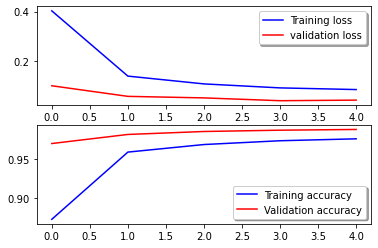

In [19]:
epochs = 5 # Change this to 35 for best results
model = model_2CMDr_2CMDr_FDDr_D()
print("Starting evaluation")
model,history = evaluate_model(model,X_train,Y_train,X_val,Y_val,"model_2CMDr_2CMDr_FDDr_D.best",epochs,64)
plot_results(history)

results = add_result("2CMDr_2CMDr_FDDr_D",history,results,0)
results

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 64)        640       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 12544)             0   

,CNN Model,Train Accuracy,Test Accuracy
0,2CMDr_2CMDr_FDDr_D,0.976283,0.988333
1,vgg_64_4,0.979463,0.988571


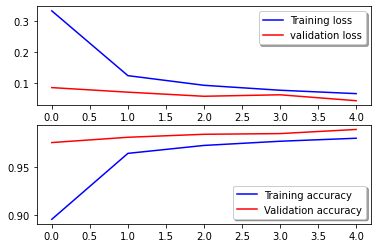

In [20]:
def vgg_model(n_filters,n_conv):
    visible = Input(shape=(28, 28, 1))
    layers= visible
    for _ in range(n_conv):
        layers = Conv2D(n_filters, (3,3), padding='same', activation='relu')(layers)
    #add max pooling layer
    layers = MaxPooling2D((2,2), strides=(2,2))(layers)
    layers = Flatten()(layers)
    output = Dense(10,activation='softmax')(layers)
    model = Model(inputs=visible, outputs=output)
    print(model.summary())
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = vgg_model(64,4)
print("Starting evaluation")
model,history = evaluate_model(model,X_train,Y_train,X_val,Y_val,"model_vgg_64_4.best",epochs,64)
plot_results(history)
results = add_result("vgg_64_4",history,results,1)
results

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 26, 26, 32)        128       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 24, 24, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 24, 24, 32)        128       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 24, 24, 32)        9248      
_________________________________________________________________
batch_normalization_3 (Batch (None, 24, 24, 32)        128       
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 12, 12, 32)       

,CNN Model,Train Accuracy,Test Accuracy
0,2CMDr_2CMDr_FDDr_D,0.976283,0.988333
1,vgg_64_4,0.979463,0.988571
2,vgg_batchNormalize,0.971142,0.985476


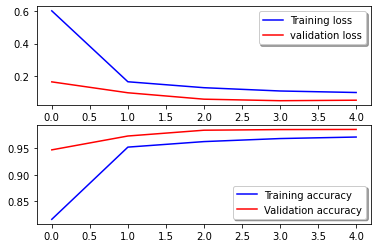

In [21]:
def model_vgg_batchNormalize():
    model = Sequential()

    model.add(Conv2D(32,kernel_size=3,activation='relu',input_shape=(28,28,1)))
    model.add(BatchNormalization())
    model.add(Conv2D(32,kernel_size=3,activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(32,kernel_size=3,activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(32,kernel_size=5,strides=2,padding='same',activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Conv2D(64,kernel_size=3,activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64,kernel_size=3,activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64,kernel_size=5,strides=2,padding='same',activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    
    model.add(BatchNormalization())
    model.add(Conv2D(256,kernel_size=3,activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(256,kernel_size=5,strides=2,padding='same',activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(Dense(10, activation='softmax'))
    print(model.summary())
    
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return model

model = model_vgg_batchNormalize()
print("Starting evaluation")
model,history = evaluate_model(model,X_train,Y_train,X_val,Y_val,"model_vgg_batchNormalize.best",epochs,64)
plot_results(history)
results = add_result("vgg_batchNormalize",history,results,2)
results

### Inception

![](https://www.jeremyjordan.me/content/images/2018/04/inception-model.png)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 28, 28, 16)   32          input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 28, 28, 16)   32          input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 28, 28, 1)    0           input_2[0][0]                    
____________________________________________________________________________________________

,CNN Model,Train Accuracy,Test Accuracy
0,2CMDr_2CMDr_FDDr_D,0.976283,0.988333
1,vgg_64_4,0.979463,0.988571
2,vgg_batchNormalize,0.971142,0.985476
3,Inception,0.97305,0.987143


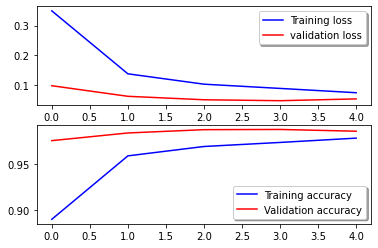

In [22]:
def model_Inception():
    input_img = Input(shape=(28, 28, 1))
    # Layer 1
    layer1_tower_0 = Conv2D(16, (1, 1), padding='same', activation='relu')(input_img)
    layer1_tower_1 = Conv2D(16, (1, 1), padding='same', activation='relu')(input_img)
    layer1_tower_1 = Conv2D(16, (3, 3), padding='same', activation='relu')(layer1_tower_1)
    
    layer1_tower_2 = Conv2D(16, (1, 1), padding='same', activation='relu')(input_img)
    layer1_tower_2 = Conv2D(16, (5, 5), padding='same', activation='relu')(layer1_tower_2)

    layer1_tower_3 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(input_img)
    layer1_tower_3 = Conv2D(16, (1, 1), padding='same', activation='relu')(layer1_tower_3)

    layer1_output = concatenate([layer1_tower_1, layer1_tower_2, layer1_tower_3, layer1_tower_0], axis=1)

    # Layer 2
    layer2_tower_0 = Conv2D(16, (1, 1), padding='same', activation='relu')(layer1_output)
    layer2_tower_1 = Conv2D(16, (1, 1), padding='same', activation='relu')(layer1_output)
    layer2_tower_1 = Conv2D(16, (3, 3), padding='same', activation='relu')(layer2_tower_1)

    layer2_tower_2 = Conv2D(16, (1, 1), padding='same', activation='relu')(layer1_output)
    layer2_tower_2 = Conv2D(16, (5, 5), padding='same', activation='relu')(layer2_tower_2)

    layer2_tower_3 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(layer1_output)
    layer2_tower_3 = Conv2D(16, (1, 1), padding='same', activation='relu')(layer2_tower_3)

    layer2_output = concatenate([layer2_tower_1, layer2_tower_2, layer2_tower_3, layer2_tower_0], axis=1)

    # Flatten & Dense
    layer2_output = Flatten()(layer2_output)
    output = Dense(10,activation='softmax')(layer2_output)
    
    inception_Model = Model(inputs=input_img,outputs=output)
    
    print(inception_Model.summary())
    inception_Model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return inception_Model

model = model_Inception()
print("Starting evaluation")
model,history = evaluate_model(model,X_train,Y_train,X_val,Y_val,"model_Inception.best",epochs,64)
plot_results(history)
results = add_result("Inception",history,results,3)
results

### XCeption

![](https://cdn-images-1.medium.com/max/1600/1*SRBSbojkg48DTUMcP5VVHg.jpeg)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_30 (Conv2D)              (None, 14, 14, 32)   320         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_12 (BatchNo (None, 14, 14, 32)   128         conv2d_30[0][0]                  
__________________________________________________________________________________________________
dropout_8 (Dropout)             (None, 14, 14, 32)   0           batch_normalization_12[0][0]     
____________________________________________________________________________________________

Epoch 1/5
 - 25s - loss: 0.9575 - accuracy: 0.7829 - val_loss: 0.3987 - val_accuracy: 0.9164

Epoch 00001: val_accuracy improved from -inf to 0.91643, saving model to model_Xception.best.hdf5
Epoch 2/5
 - 23s - loss: 0.4027 - accuracy: 0.9207 - val_loss: 0.2094 - val_accuracy: 0.9674

Epoch 00002: val_accuracy improved from 0.91643 to 0.96738, saving model to model_Xception.best.hdf5
Epoch 3/5
 - 21s - loss: 0.2937 - accuracy: 0.9423 - val_loss: 0.1471 - val_accuracy: 0.9738

Epoch 00003: val_accuracy improved from 0.96738 to 0.97381, saving model to model_Xception.best.hdf5
Epoch 4/5
 - 22s - loss: 0.2191 - accuracy: 0.9519 - val_loss: 0.1115 - val_accuracy: 0.9733

Epoch 00004: val_accuracy did not improve from 0.97381
Epoch 5/5
 - 23s - loss: 0.1754 - accuracy: 0.9604 - val_loss: 0.0915 - val_accuracy: 0.9774

Epoch 00005: val_accuracy improved from 0.97381 to 0.97738, saving model to model_Xception.best.hdf5


,CNN Model,Train Accuracy,Test Accuracy
0,2CMDr_2CMDr_FDDr_D,0.976283,0.988333
1,vgg_64_4,0.979463,0.988571
2,vgg_batchNormalize,0.971142,0.985476
3,Inception,0.97305,0.987143
4,Xception,0.960436,0.977381


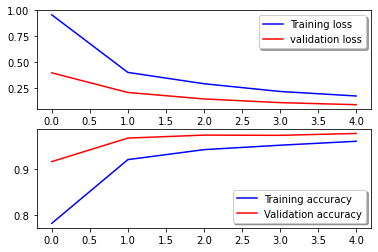

In [23]:
def model_Xception():
    inp = Input(shape = (28, 28, 1))
    x = inp
    x = Conv2D(32, (3, 3), strides = 2, padding = "same", activation = "relu")(x)
    x = BatchNormalization(axis = 3)(x)
    x = Dropout(0.4)(x)
    x = Conv2D(64, (3, 3), strides = 1, padding = "same", activation = "relu")(x)
    x = BatchNormalization(axis = 3)(x)
    x = Dropout(0.4)(x)

    x1 = DepthwiseConv2D((3, 3), (1, 1), padding = "same", activation = "relu")(x)
    x = BatchNormalization(axis = 3)(x)
    x = Dropout(0.4)(x)
    x1 = DepthwiseConv2D((3, 3), (1, 1), padding = "same", activation = "relu")(x1)
    x = BatchNormalization(axis = 3)(x)
    x = Dropout(0.4)(x)
    x1 = MaxPooling2D((2, 2), strides = 1)(x1)

    x = concatenate([x1, Conv2D(64, (2, 2), strides = 1)(x)])

    x1 = Activation("relu")(x)
    x1 = Conv2D(256, (3, 3), strides = 1, padding = "same", activation = "relu")(x1)
    x = BatchNormalization(axis = 3)(x)
    x = Dropout(0.4)(x)
    x1 = DepthwiseConv2D((3, 3), strides = 1, padding = "same", activation = "relu")(x1)
    x = BatchNormalization(axis = 3)(x)
    x = Dropout(0.4)(x)
    x1 = DepthwiseConv2D((3, 3), strides = 1, padding = "same")(x1)
    x = BatchNormalization(axis = 3)(x)
    x = Dropout(0.4)(x)
    x1 = MaxPooling2D((2, 2), strides = 1)(x1)

    x = concatenate([x1, Conv2D(256, (2, 2), strides = 1)(x)])

    x = Activation("relu")(x)
    x = Conv2D(256, (3, 3), strides = 1, padding = "same", activation = "relu")(x)
    x = BatchNormalization(axis = 3)(x)
    x = Dropout(0.4)(x)
    x = Conv2D(128, (3, 3), strides = 1, padding = "same", activation = "relu")(x)
    x = BatchNormalization(axis = 3)(x)
    x = Dropout(0.4)(x)
    x = Flatten()(x)

    x = Dense(10, activation = "softmax")(x)

    xception = Model(inp, x)
    print(xception.summary())
    xception.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return xception

model = model_Xception()
print("Starting evaluation")
model,history = evaluate_model(model,X_train,Y_train,X_val,Y_val,"model_Xception.best",epochs,64)
plot_results(history)
results = add_result("Xception",history,results,4)
results

## Select model and predict test data
Select the best model and best weights and use it to predict results.

In [24]:
results

,CNN Model,Train Accuracy,Test Accuracy
0,2CMDr_2CMDr_FDDr_D,0.976283,0.988333
1,vgg_64_4,0.979463,0.988571
2,vgg_batchNormalize,0.971142,0.985476
3,Inception,0.97305,0.987143
4,Xception,0.960436,0.977381


Above results are just for 5 epochs, increasing epochs to 35,40 giving better results.

In [25]:
## predict results
# model = model_2CMDr_2CMDr_FDDr_D()  #99.214%
# model = vgg_model(64,4) #99.476%
model = model_vgg_batchNormalize()  #99.73%
# model = model_Inception()  #99.21%
# model = model_Xception()  #99.57%

model.load_weights("model_vgg_batchNormalize.best.hdf5")

test_data = input_test.values.reshape(-1,28,28,1)
outputs = model.predict(test_data)

# select the index with the maximum probability
outputs = np.argmax(outputs,axis = 1)

outputs = pd.Series(outputs,name="Label")
outputs

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_37 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization_21 (Batc (None, 26, 26, 32)        128       
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 24, 24, 32)        9248      
_________________________________________________________________
batch_normalization_22 (Batc (None, 24, 24, 32)        128       
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 24, 24, 32)        9248      
_________________________________________________________________
batch_normalization_23 (Batc (None, 24, 24, 32)        128       
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 12, 12, 32)       

0        2
1        0
2        9
3        0
4        3
        ..
27995    9
27996    7
27997    3
27998    9
27999    2
Name: Label, Length: 28000, dtype: int64

### Submission
Select your best model and create a submission

In [26]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),outputs],axis = 1)

#submission.to_csv("submision_Inception.csv",index=False)
submission

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3
...,...,...
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9


### You can increase epochs and tune parameters for better results.

I've not included the therotical details of the models in this notebook. I hope you can read about those internet and learn.

ResNet and Dense Net models are in the pipeline... working on those.


### Please upvote if you findout this notebook helpful. 
Thank you.